# 루브릭
1. 번역기 모델 학습에 필요한 텍스트 데이터 전처리가 한국어 포함하여 잘 이루어졌다.  
   구두점, 대소문자, 띄어쓰기, 한글형태소분석 등 번역기 모델에 요구되는 전처리가 정상적으로 진행  
2. Attentional Seq2seq 모델이 정상적으로 구동  
   seq2seq 모델 훈련 과정에서 training loss가 안정적으로 떨어지면서 학습이 진행됨.  
3. 테스트 결과 의미가 통하는 수준의 번역문이 생성  
   테스트용 디코더 모델이 정상적으로 만들어져서, 정답과 어느 정도 유사한 영어 번역이 진행됨.  

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import matplotlib.ticker as ticker

%config InlineBackend.figure_format = 'retina'

# 폰트 경로 설정
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)

# 폰트를 matplotlib의 기본 폰트로 설정
plt.rcParams['font.family'] = font.get_name()

# 폰트 설정 확인
print(mpl.font_manager.findfont(font))

/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf


In [2]:
import os
import pandas as pd

import re
from konlpy.tag import Mecab

import tensorflow as tf
import numpy as np

2024-07-10 09:46:50.675046: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-10 09:46:51.538914: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# Step 1. 데이터 다운로드
[jungyeul/korean-parallel-corpora](https://github.com/jungyeul/korean-parallel-corpora/tree/master/korean-english-news-v1)

# Step 2. 데이터 정제
1. set 데이터형이 중복을 허용하지 않는다는 것을 활용해 중복된 데이터 제거. 데이터의 병렬 쌍이 흐트러지지 않게 주의. 중복을 제거한 데이터를 cleaned_corpus에 저장
2. preprocessing() 함수는 한글에서 동작하지 않음. 한글에 적용할 수 있는 정규식을 추가하여 함수 재정의
3. 타겟 언어인 영문엔 \<start\>토큰과 \<end\>토큰을 추가. split() 함수를 이용하여 토큰화함. 한글 토큰화는 KoNLPy의 mecab 클래스 사용.  
clearned_corpus로부터 토큰의 길이가 40 이하인 데이터를 선별하여 eng_corpus와 kor_corpus 구축

## 데이터 불러오기

In [3]:
working_dir = os.getcwd()
data_dir = os.path.join(working_dir, 'data')

In [4]:
# 데이터 불러오기
file_ko = os.path.join(data_dir, 'korean-english-park.train.ko')
file_en = os.path.join(data_dir, 'korean-english-park.train.en')

print('korean data')
with open(file_ko, 'r') as f:
    for i in range(10):
        line = f.readline().strip()
        print(line)

print('\n'*2)
print('english data')
with open(file_en, 'r') as f:
    for i in range(10):
        line = f.readline().strip()
        print(line)

korean data
개인용 컴퓨터 사용의 상당 부분은 "이것보다 뛰어날 수 있느냐?"
모든 광마우스와 마찬가지 로 이 광마우스도 책상 위에 놓는 마우스 패드를 필요로 하지 않는다.
그러나 이것은 또한 책상도 필요로 하지 않는다.
79.95달러하는 이 최첨단 무선 광마우스는 허공에서 팔목, 팔, 그외에 어떤 부분이든 그 움직임에따라 커서의 움직임을 조절하는 회전 운동 센서를 사용하고 있다.
정보 관리들은 동남 아시아에서의 선박들에 대한 많은 (테러) 계획들이 실패로 돌아갔음을 밝혔으며, 세계 해상 교역량의 거의 3분의 1을 운송하는 좁은 해로인 말라카 해협이 테러 공격을 당하기 쉽다고 경고하고 있다.
이 지역에 있는 미국 선박과 상업용 선박들에 대한 알카에다의 (테러) 시도 중 여러 건이 실패했다는 것을 알게 된 후에, 전문가들은 테러 조직이 여전히 세계 경제에 타격을 입히려 한다고 경고하고 있으며, 동남 아시아에 있는 세계 경제의 주요 통로가 위험에 처해 있다고 그들은 생각하고 있다.
국립 과학 학회가 발표한 새 보고서에따르면, 복잡한 임무를 수행해야 하는 군인들이나 보다 오랜 시간 동안 경계를 늦추지 않고 있기 위해 도움이 필요한 군인들에게 카페인이 반응 시간을 증가시키고 임무 수행 능력을 향상시키는데 도움이 된다고 한다.
이 보고서에따르면, "특히, 군사 작전에서 생사가 걸린 상황이 될 수도 있는 반응 속도와 시각 및 청각의 경계 상태를 유지시키기 위해 카페인이 사용될 수도 있다." 고 한다.
"결정적인 순간에 그들의 능력을 증가시켜 줄 그 무엇이 매우 중요합니다."
연구가들이 이미 커피 대체품으로서 음식 대용 과자나 껌에 카페인을 첨가하는 방법을 연구하고 있다고 Archibald는 말했다.



english data
Much of personal computing is about "can you top this?"
so a mention a few weeks ago about a rechargeable wireless optical mouse brou

In [5]:
# with open(file_ko, 'r') as f:
#     data_ko = [line.strip() for line in f]

# with open(file_en, 'r') as f:
#     data_en = [line.strip() for line in f]

# df = pd.DataFrame(zip(data_ko, data_en))
# df.columns = ['korean', 'english']
# df.head()

# df.to_csv(
#     os.path.join(data_dir, 'translation_data.csv'),
#     index = False,
#     encoding = 'utf-8-sig'
# )

In [6]:
df = pd.read_csv(os.path.join(data_dir, 'translation_data.csv'))
df.head()

,korean,english
0,"개인용 컴퓨터 사용의 상당 부분은 ""이것보다 뛰어날 수 있느냐?""","Much of personal computing is about ""can you t..."
1,모든 광마우스와 마찬가지 로 이 광마우스도 책상 위에 놓는 마우스 패드를 필요로 하...,so a mention a few weeks ago about a rechargea...
2,그러나 이것은 또한 책상도 필요로 하지 않는다.,"Like all optical mice, But it also doesn't nee..."
3,"79.95달러하는 이 최첨단 무선 광마우스는 허공에서 팔목, 팔, 그외에 어떤 부분...",uses gyroscopic sensors to control the cursor ...
4,정보 관리들은 동남 아시아에서의 선박들에 대한 많은 (테러) 계획들이 실패로 돌아갔...,Intelligence officials have revealed a spate o...


## 중복 데이터 제거 후 cleaned_corpus에 저장

In [7]:
print(df.shape)
cleaned_corpus = df.drop_duplicates()
print(cleaned_corpus.shape)

(94123, 2)
(78941, 2)


## 데이터 정제하기

In [8]:
def preprocess_sentence(sentence, s_token=False, e_token=False):
    sentence = sentence.lower().strip()

    sentence = re.sub(r"([?.,!])", r" \1 ", sentence)
    sentence = re.sub(r'\bthe\b', '', sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)
    sentence = re.sub(r"[^ㄱ-ㅣ가-힣a-zA-Z?.!]+", " ", sentence)

    sentence = sentence.strip()

    if s_token:
        sentence = '<start> ' + sentence

    if e_token:
        sentence += ' <end>'
    
    return sentence

In [9]:
num_examples = len(cleaned_corpus)

enc_corpus = cleaned_corpus['korean'].apply(preprocess_sentence)
dec_corpus = cleaned_corpus['english'].apply(preprocess_sentence,
                                             s_token = True, e_token = True)

print('enc_corpus', type(enc_corpus), enc_corpus[100])
print('dec_corpus', type(dec_corpus), dec_corpus[100])

enc_corpus <class 'pandas.core.series.Series'> 제 차 연례 컴덱스 박람회의 개회사를 한 케이츠는 년여전 기술 산업의 거품이 붕괴된 이후에 첨단 기술에 대해 부정적인 인식이 있다고 말했다 .
dec_corpus <class 'pandas.core.series.Series'> <start> gates who opened rd annual comdex trade show said there was a negative perception of high tech following collapse of tech bubble about two years ago . <end>


# Step 3. 데이터  토큰화
앞서 정의한 tokenize() 함수를 사용해 데이터를 텐서로 변환. 각각의 tokenizer를 얻기.  
단어의 수는 실험을 통해 적당한 값을 맞춤.(최소 10,000 이상)  
훈련 데이터와 검증 데이터를 따로 나누지 않음.

In [10]:
def tokenize_with_mecab(corpus):
    mecab = Mecab()
    tokenized_corpus = []
    for sentence in corpus:
        tokens = mecab.morphs(sentence)
        tokenized_corpus.append(' '.join(tokens))
    return tokenized_corpus

def filter_by_tokens_length(enc_corpus, dec_corpus, max_len = 40):
    filtered_enc_corpus = []
    filtered_dec_corpus = []

    for enc_sent, dec_sent in zip(enc_corpus, dec_corpus):
        enc_tokens = enc_sent.split()
        dec_tokens = dec_sent.split()

        if len(enc_tokens) <= max_len and len(dec_tokens) <= max_len:
            filtered_enc_corpus.append(enc_sent)
            filtered_dec_corpus.append(dec_sent)
    
    return filtered_enc_corpus, filtered_dec_corpus

def tokenize(corpus, num_words = None):
    tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words = num_words, filters='')
    tokenizer.fit_on_texts(corpus)

    tensor = tokenizer.texts_to_sequences(corpus)

    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor,
                                                           padding='post')

    return tensor, tokenizer

In [11]:
enc_corpus = tokenize_with_mecab(enc_corpus)

enc_corpus, dec_corpus = filter_by_tokens_length(enc_corpus, dec_corpus)

enc_tensor, enc_tokenizer = tokenize(enc_corpus)
dec_tensor, dec_tokenizer = tokenize(dec_corpus)

print(enc_tensor.shape)
print(dec_tensor.shape)

(65332, 40)
(65332, 40)


# Step 4. 모델 설계
Attention 기반 Seq2Seq 모델을 설계.  
앞서 만든 모델에 Dropout 모듈을 추가하면 성능이 더 좋아짐.  
Embedding Size와 Hidden Size는 실험을 통해 적당한 값을 맞추기.

In [12]:
class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.w_dec = tf.keras.layers.Dense(units)
        self.w_enc = tf.keras.layers.Dense(units)
        self.w_com = tf.keras.layers.Dense(1)
    
    def call(self, h_enc, h_dec):
        # h_enc shape: [batch x length x units]
        # h_dec shape: [batch x units]

        h_enc = self.w_enc(h_enc)
        h_dec = tf.expand_dims(h_dec, 1)
        h_dec = self.w_dec(h_dec)

        score = self.w_com(tf.nn.tanh(h_dec + h_enc))
        
        attn = tf.nn.softmax(score, axis=1)

        context_vec = attn * h_enc
        context_vec = tf.reduce_sum(context_vec, axis=1)

        return context_vec, attn

In [13]:
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units):
        super(Encoder, self).__init__()
        self.enc_units = enc_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(enc_units,
                                       return_sequences=True,
                                    #    dropout = 0.2,
                                    #    recurrent_dropout = 0.2
                                       )
		
    def call(self, x):
        out = self.embedding(x)
        out = self.gru(out)
        
        return out

In [14]:
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units):
        super(Decoder, self).__init__()
        self.dec_units = dec_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru1 = tf.keras.layers.GRU(dec_units,
                                        return_sequences=True,
                                        return_state=True,
                                        # dropout = 0.2,
                                        # recurrent_dropout = 0.2
                                        )
        # self.gru2 = tf.keras.layers.GRU(dec_units,
        #                                 return_sequences=True,
        #                                 return_state=True,
        #                                 dropout = 0.2,
        #                                 recurrent_dropout = 0.2
        #                                 )
        self.fc = tf.keras.layers.Dense(vocab_size,
                                        # dropout = 0.2
                                        )

        self.attention = BahdanauAttention(self.dec_units)   # Attention 필수 사용!

    def call(self, x, h_dec, enc_out):
        context_vec, attn = self.attention(enc_out, h_dec)

        out = self.embedding(x)
        out = tf.concat([tf.expand_dims(context_vec, 1), out], axis=-1)
        
        out, h_dec1 = self.gru1(out)
        # out, h_dec2 = self.gru2(out)
        out = tf.reshape(out, (-1, out.shape[2]))
        out = self.fc(out)

        return out, h_dec1, attn

In [15]:
# 코드를 실행하세요.

BATCH_SIZE     = 64
SRC_VOCAB_SIZE = len(enc_tokenizer.index_word) + 1
TGT_VOCAB_SIZE = len(dec_tokenizer.index_word) + 1

units         = 1024
embedding_dim = 512

encoder = Encoder(SRC_VOCAB_SIZE, embedding_dim, units)
decoder = Decoder(TGT_VOCAB_SIZE, embedding_dim, units)

# sample input
sequence_len = 30

sample_enc = tf.random.uniform((BATCH_SIZE, sequence_len))
sample_output = encoder(sample_enc)

print ('Encoder Output:', sample_output.shape)

sample_state = tf.random.uniform((BATCH_SIZE, units))

sample_logits, h_dec, attn = decoder(tf.random.uniform((BATCH_SIZE, 1)),
                                     sample_state, sample_output)

print ('Decoder Output:', sample_logits.shape)
print ('Decoder Hidden State:', h_dec.shape)
print ('Attention:', attn.shape)

2024-07-10 09:47:13.595736: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 20628 MB memory:  -> device: 0, name: NVIDIA RTX A5000, pci bus id: 0000:02:00.0, compute capability: 8.6
2024-07-10 09:47:14.912268: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2024-07-10 09:47:14.954047: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


Encoder Output: (64, 30, 1024)
Decoder Output: (64, 39481)
Decoder Hidden State: (64, 1024)
Attention: (64, 30, 1)


# Step 5. 훈련하기
위에서 사용한 코드를 그대로 사용하되, eval_step() 부분이 없음.  
매 스텝 아래의 예문에 대한 번역을 생성하여 본인이 생각하기에 가장 멋지게 번역한 Case를 제출  
## 예문 ##
K1) 오바마는 대통령이다.  
K2) 시민들은 도시 속에 산다.  
K3) 커피는 필요 없다.  
K4) 일곱 명의 사망자가 발생했다.  
## 제출 ##
E1) obama is the president . <end>  
E2) people are victims of the city . <end>  
E2) the price is not enough . <end>  
E2) seven people have died . <end>  

## Optimizer & Loss

In [16]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss = loss_object(real, pred)
    
    mask = tf.cast(mask, dtype=loss.dtype)
    loss *= mask
    
    return tf.reduce_mean(loss)

## train_step 구현

In [17]:
@tf.function
def train_step(src, tgt, encoder, decoder, optimizer, dec_tok):
    bsz = src.shape[0]
    loss = 0

    with tf.GradientTape() as tape:
        enc_out = encoder(src)
        h_dec = enc_out[:, -1]
        
        dec_src = tf.expand_dims([dec_tok.word_index['<start>']] * bsz, 1)

        for t in range(1, tgt.shape[1]):
            pred, h_dec, _ = decoder(dec_src, h_dec, enc_out)

            loss += loss_function(tgt[:, t], pred)
            dec_src = tf.expand_dims(tgt[:, t], 1)
        
    batch_loss = (loss / int(tgt.shape[1]))

    variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, variables)
    optimizer.apply_gradients(zip(gradients, variables))
    
    return batch_loss

## 훈련

In [18]:
from tqdm import tqdm    # tqdm
import random

EPOCHS = 5

for epoch in range(EPOCHS):
    total_loss = 0
    
    idx_list = list(range(0, enc_tensor.shape[0], BATCH_SIZE))
    random.shuffle(idx_list)
    t = tqdm(idx_list)    # tqdm

    for (batch, idx) in enumerate(t):
        batch_loss = train_step(enc_tensor[idx:idx+BATCH_SIZE],
                                dec_tensor[idx:idx+BATCH_SIZE],
                                encoder,
                                decoder,
                                optimizer,
                                dec_tokenizer)
    
        total_loss += batch_loss
        
        t.set_description_str('Epoch %2d' % (epoch + 1))    # tqdm
        t.set_postfix_str('Loss %.4f' % (total_loss.numpy() / (batch + 1)))    # tqdm

  0%|          | 0/1021 [00:00<?, ?it/s]

2024-07-10 09:48:02.870609: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x76f8a4e79d00 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-07-10 09:48:02.870656: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA RTX A5000, Compute Capability 8.6
2024-07-10 09:48:02.878252: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-07-10 09:48:03.076460: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
Epoch  5: 100%|██████████| 1021/1021 [03:07<00:00,  5.46it/s, Loss 2.5496]


In [19]:
def evaluate(sentence, encoder, decoder):
    attention = np.zeros((dec_tensor.shape[-1], enc_tensor.shape[-1]))
    mecab = Mecab()
    
    sentence = preprocess_sentence(sentence)
    sentence = mecab.morphs(sentence)
    inputs = enc_tokenizer.texts_to_sequences([sentence])
    inputs = tf.keras.preprocessing.sequence.pad_sequences(inputs,
                                                           maxlen=enc_tensor.shape[-1],
                                                           padding='post')

    result = ''

    enc_out = encoder(inputs)

    dec_hidden = enc_out[:, -1]
    dec_input = tf.expand_dims([dec_tokenizer.word_index['<start>']], 0)

    for t in range(dec_tensor.shape[-1]):
        predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                             dec_hidden,
                                                             enc_out)

        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention[t] = attention_weights.numpy()

        predicted_id = \
        tf.argmax(tf.math.softmax(predictions, axis=-1)[0]).numpy()

        result += dec_tokenizer.index_word[predicted_id] + ' '

        if dec_tokenizer.index_word[predicted_id] == '<end>':
            return result, sentence, attention

        dec_input = tf.expand_dims([predicted_id], 0)

    return result, sentence, attention


def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')

    fontdict = {'fontsize': 14}

    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90, fontproperties = font)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict, fontproperties = font)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()


def translate(sentence, encoder, decoder):
    result, sentence, attention = evaluate(sentence, encoder, decoder)

    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))
    
    attention = attention[:len(result.split()), :len(sentence)]
    plot_attention(attention, sentence, result.split(' '))

Input: ['오바마', '는', '대통령', '이', '다', '.']
Predicted translation: obama is a lot of obama . <end> 


/tmp/ipykernel_1520386/3675787908.py:47: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90, fontproperties = font)
/tmp/ipykernel_1520386/3675787908.py:48: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict, fontproperties = font)


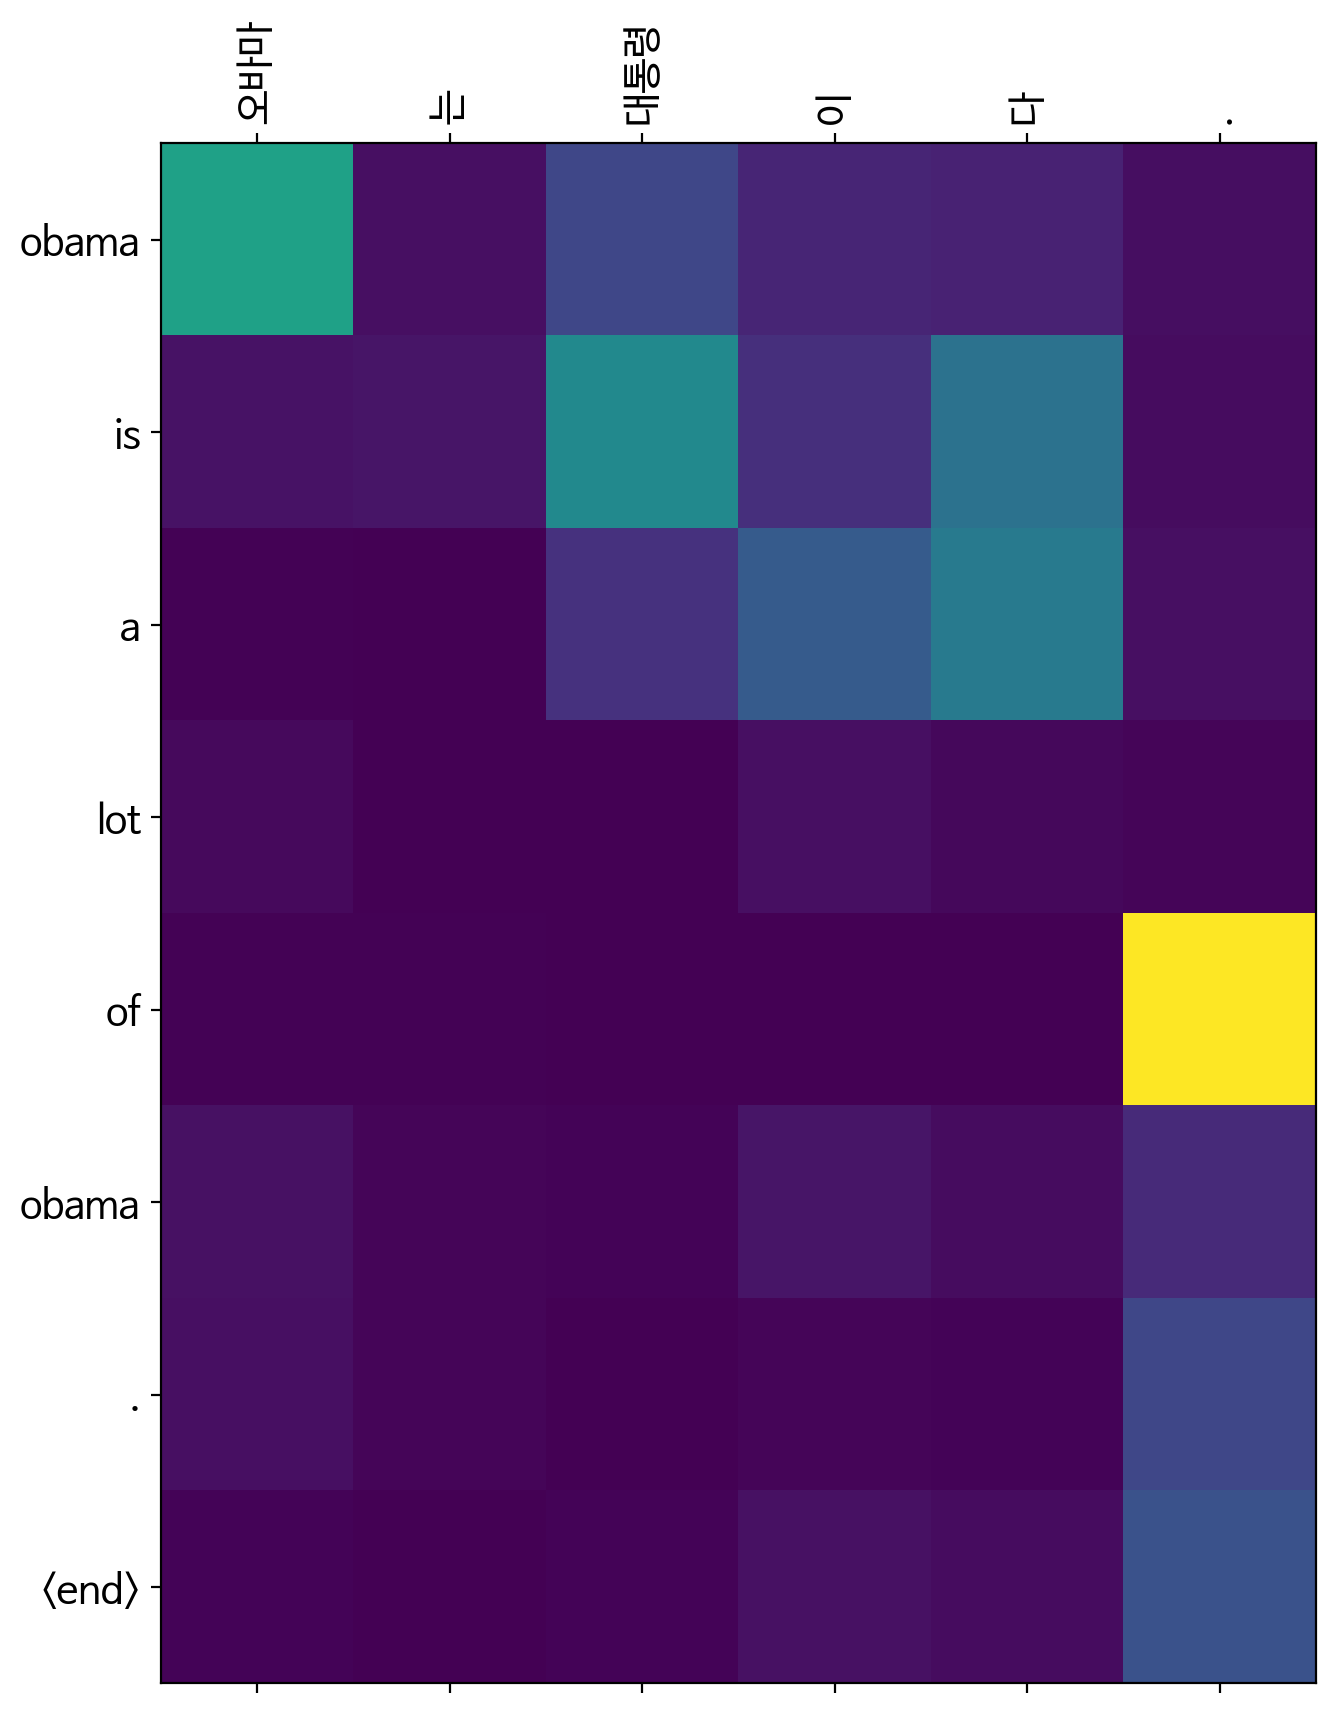

Input: ['시민', '들', '은', '도시', '속', '에', '산다', '.']
Predicted translation: they were in a year . <end> 


/tmp/ipykernel_1520386/3675787908.py:47: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90, fontproperties = font)
/tmp/ipykernel_1520386/3675787908.py:48: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict, fontproperties = font)


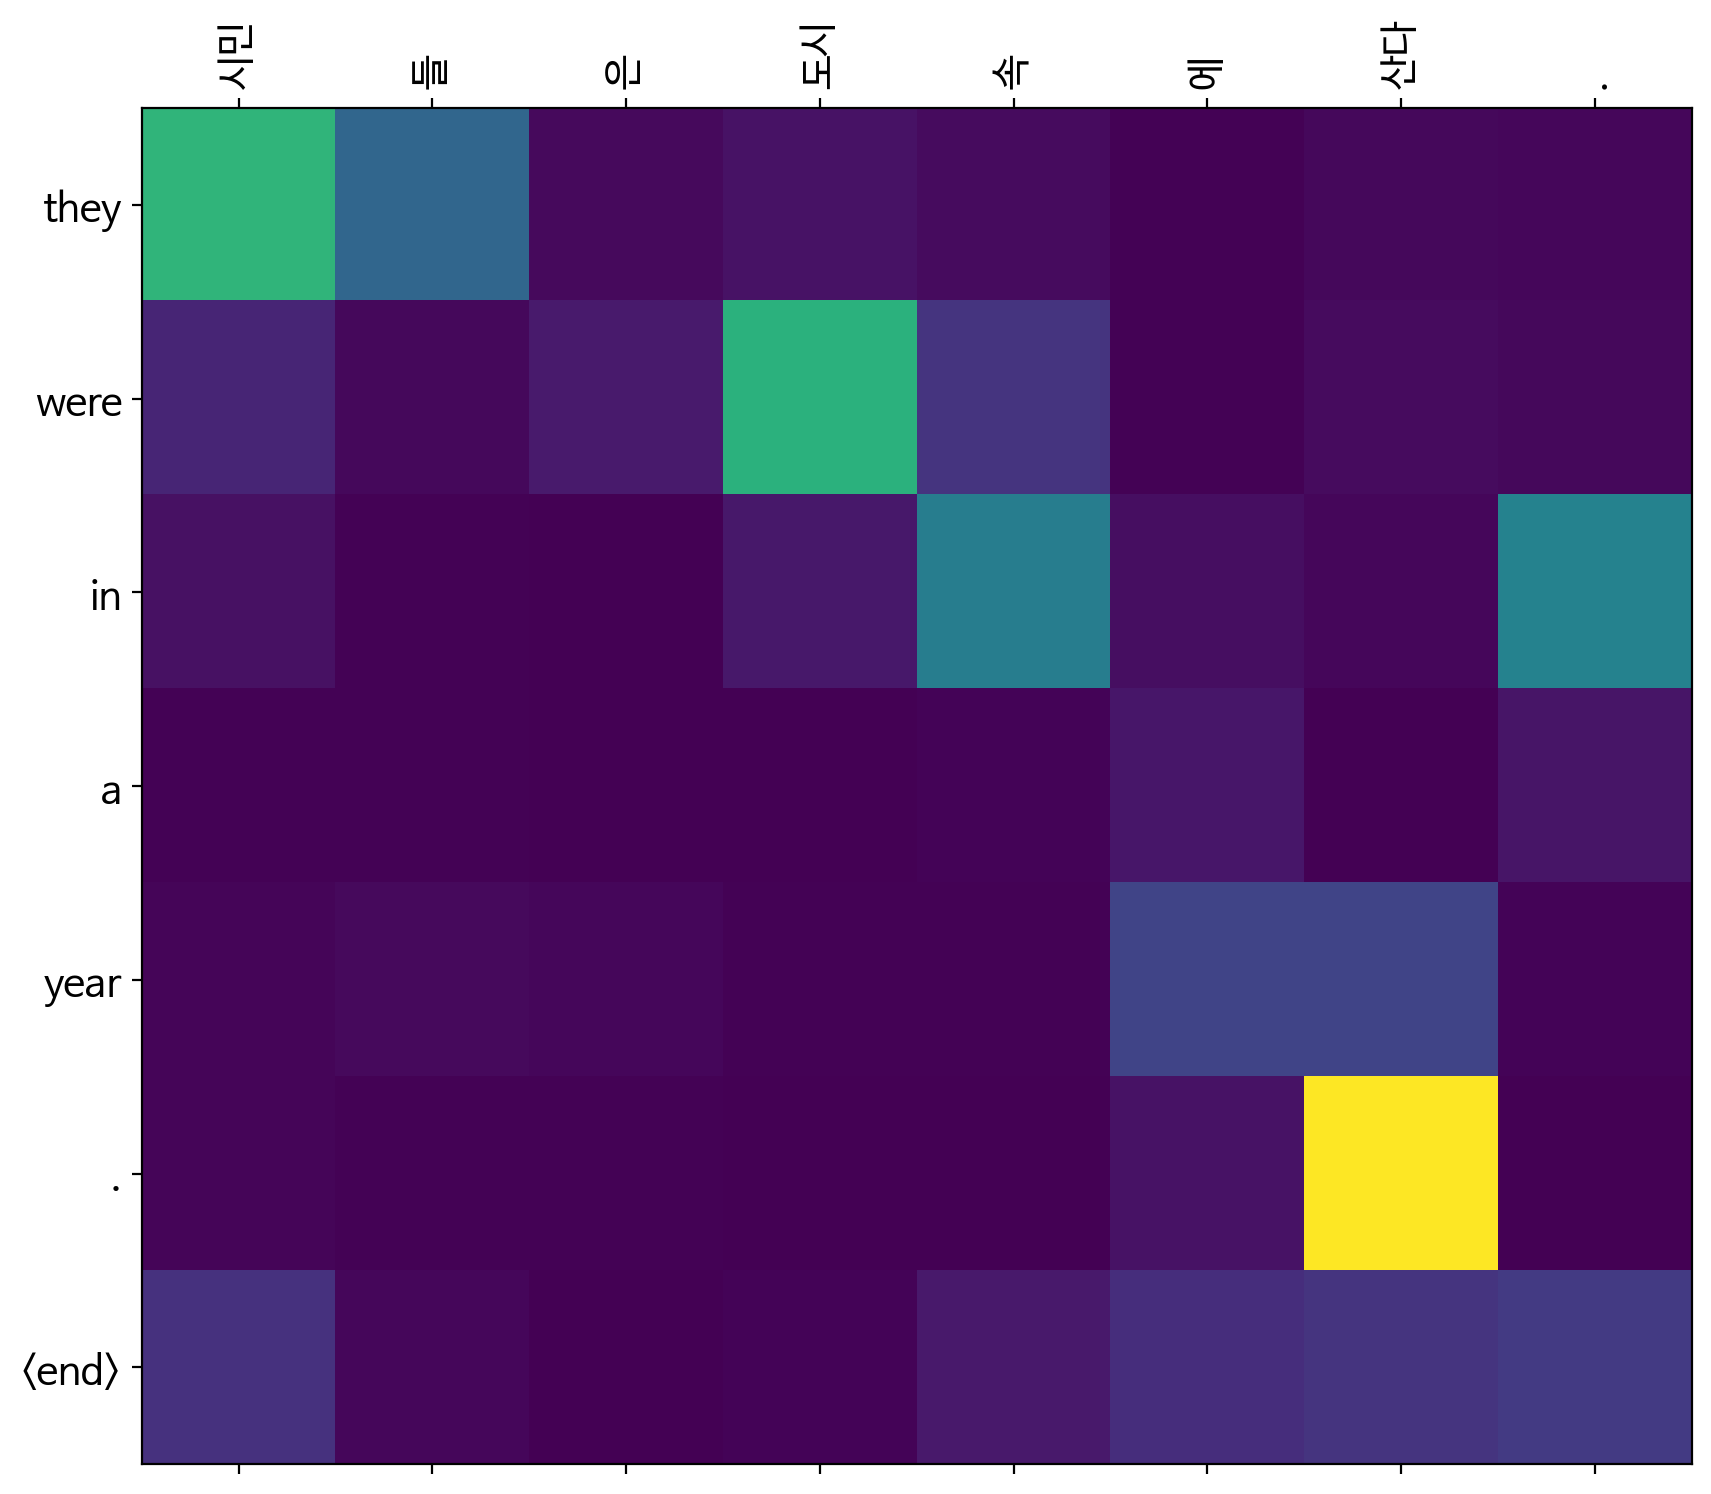

Input: ['커피', '는', '필요', '없', '다', '.']
Predicted translation: you can t have a lot of a few days . <end> 


/tmp/ipykernel_1520386/3675787908.py:47: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90, fontproperties = font)
/tmp/ipykernel_1520386/3675787908.py:48: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict, fontproperties = font)


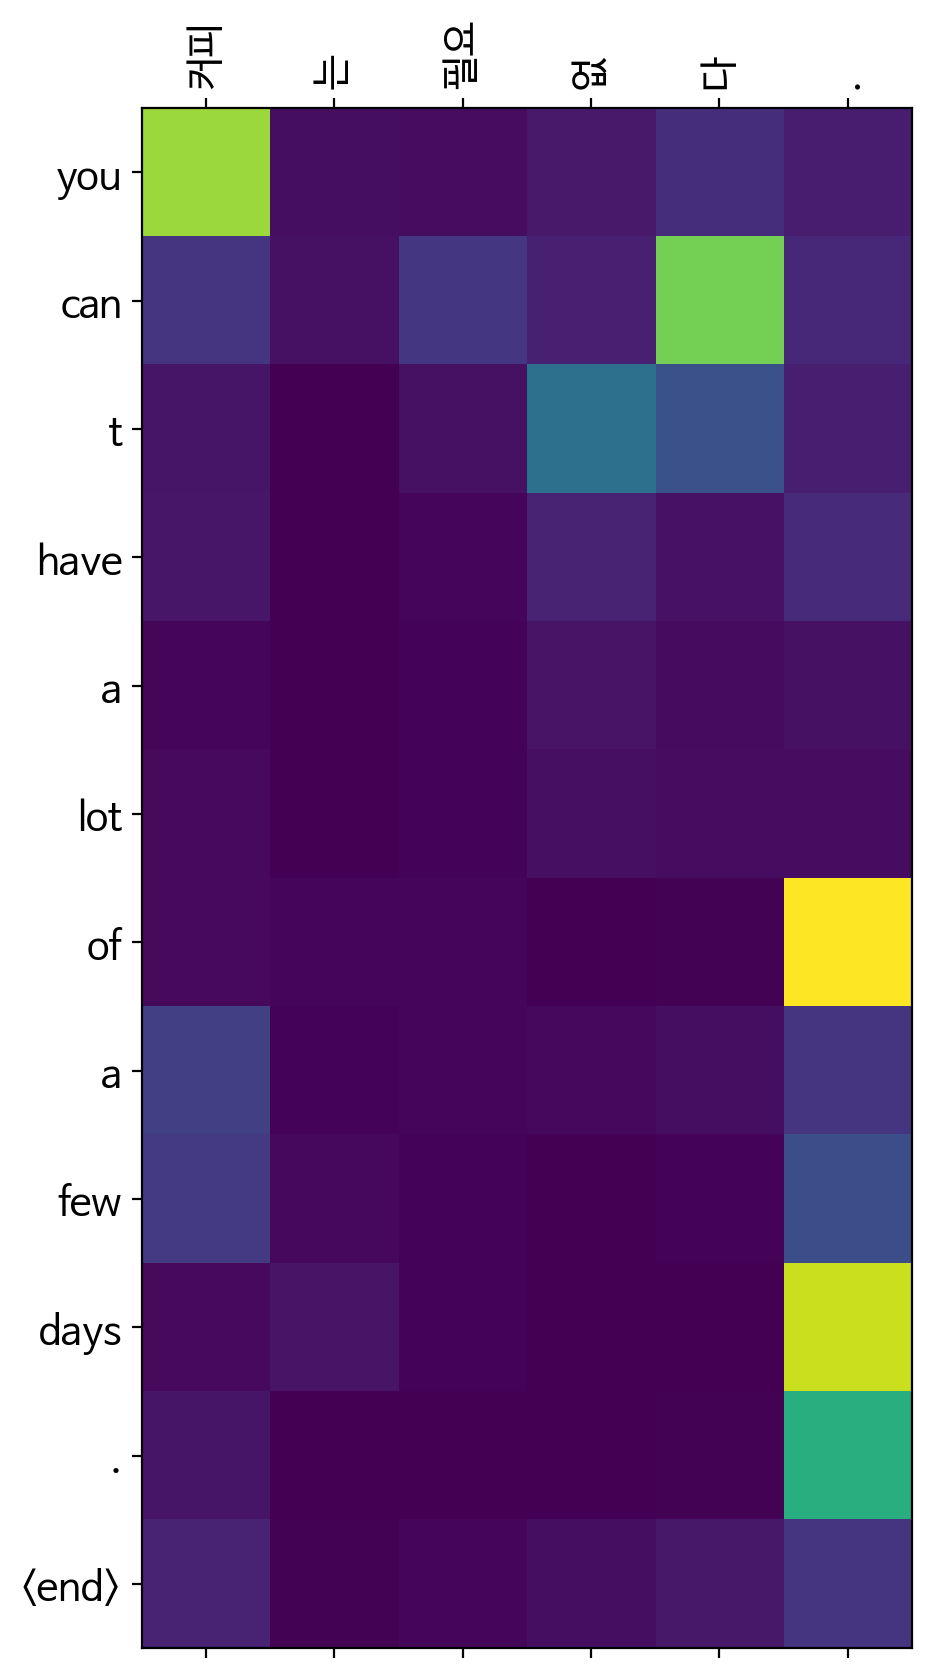

Input: ['일곱', '명', '의', '사망자', '가', '발생', '했', '다', '.']
Predicted translation: at least people died in a year old official said . <end> 


/tmp/ipykernel_1520386/3675787908.py:47: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90, fontproperties = font)
/tmp/ipykernel_1520386/3675787908.py:48: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict, fontproperties = font)


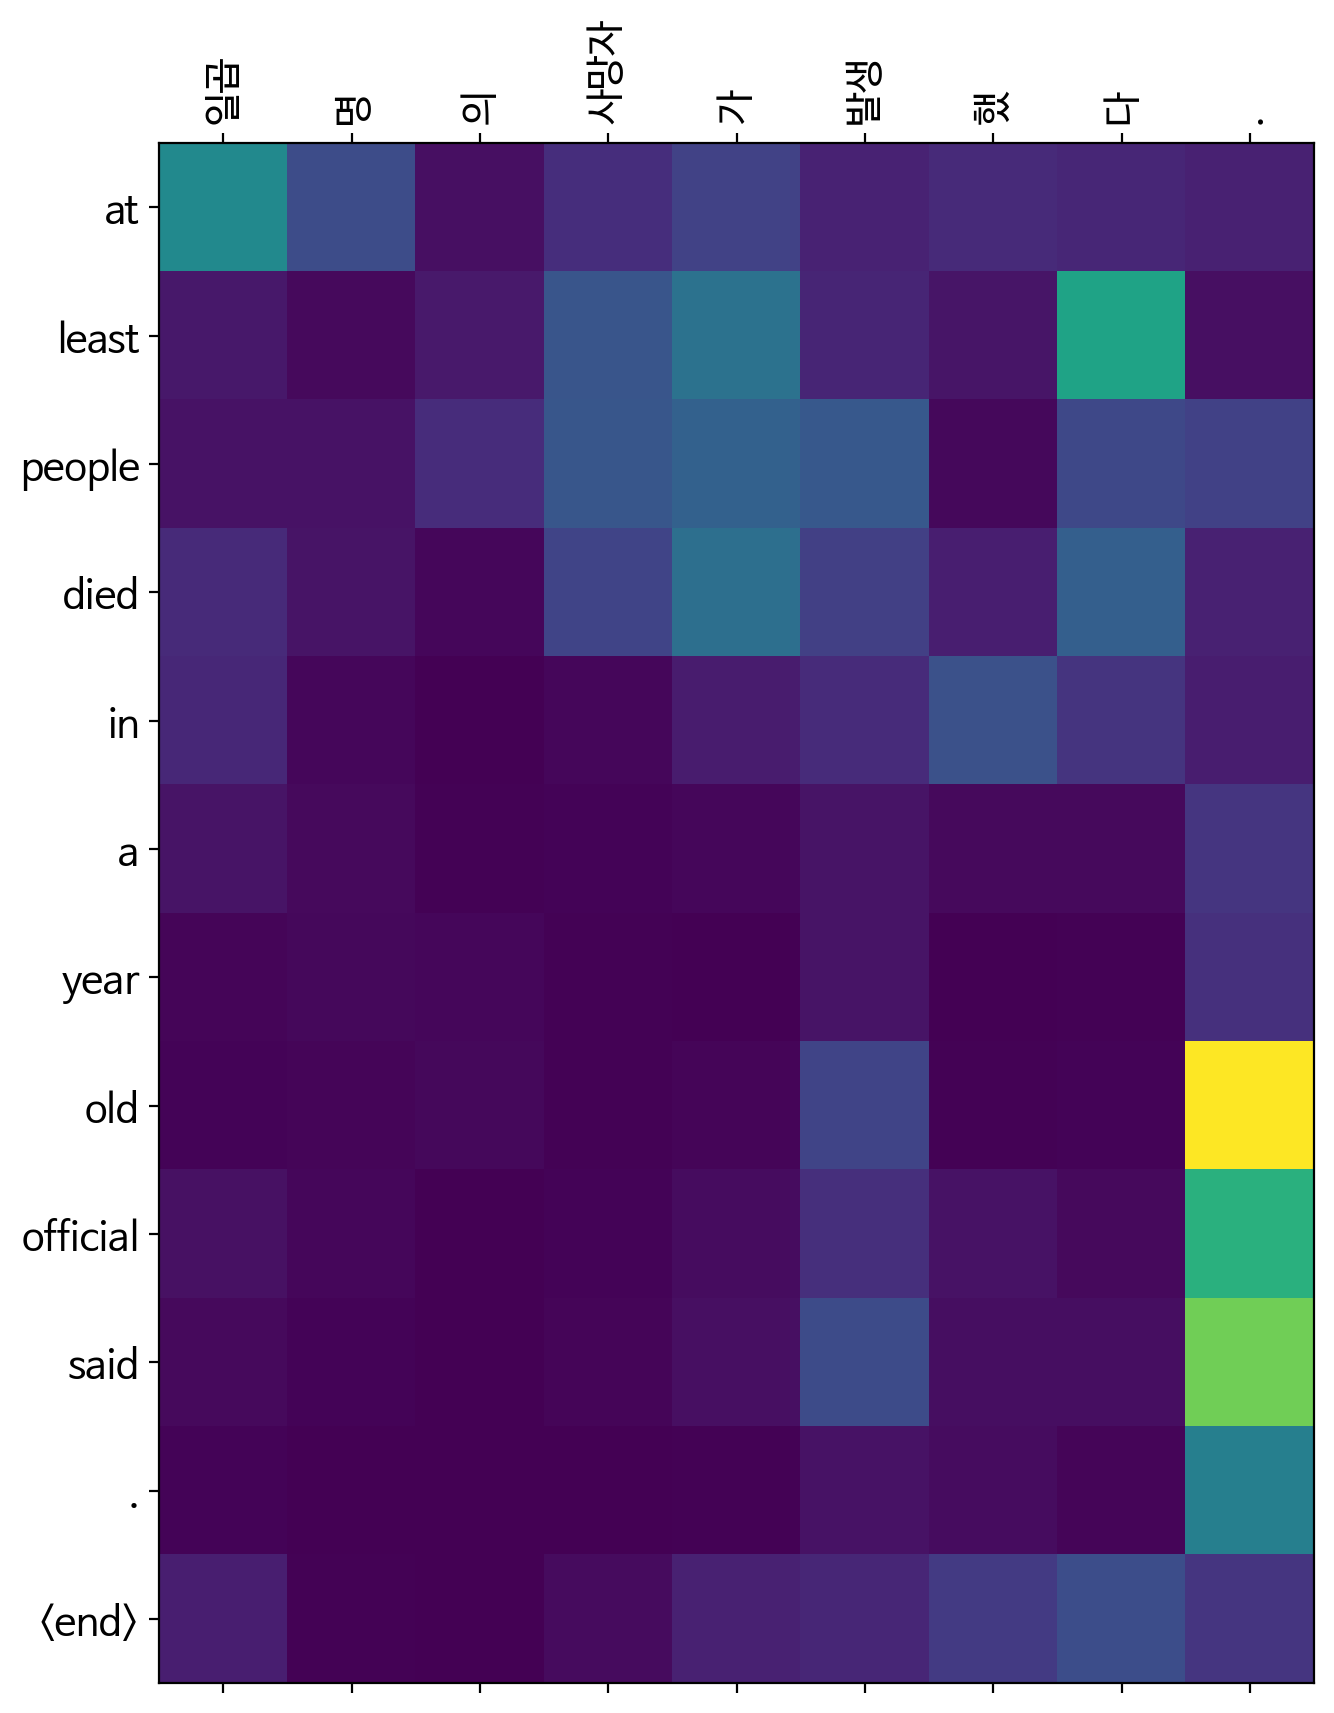

In [20]:
enc_test = [
    '오바마는 대통령이다.',
    '시민들은 도시 속에 산다.',
    '커피는 필요 없다.',
    '일곱 명의 사망자가 발생했다.'
]

for doc in enc_test:
    translate(doc, encoder, decoder)